In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,8)

## Original Image

![title](input.d/pinchOff-0.png)

## Contour Plot

1280 800


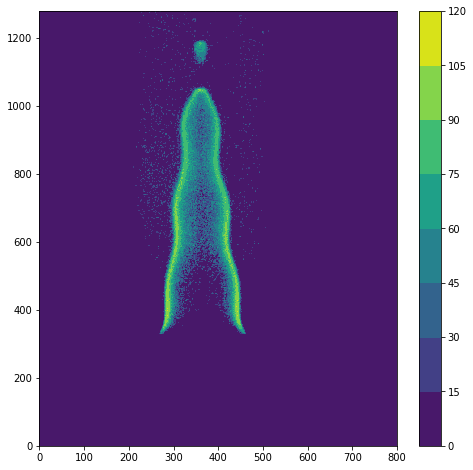

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

np_map = imageio.imread("input.d/pinchOff-0.png").T[::-1, ::-1]
height, width = np_map.shape
print(height, width)

plt.figure(1)
plt.contourf(np_map)
plt.colorbar()
plt.show()

## Set Threshold

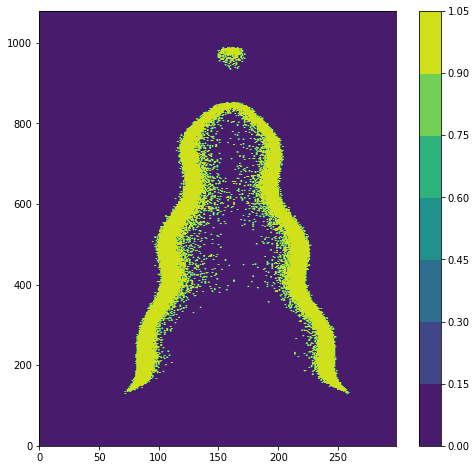

In [3]:
def threshold(np_map, THRESH=55):
    res = np.copy(np_map)
    res[np_map <= THRESH] = False
    res[np_map > THRESH] = True
    return res

np_map1 = threshold(np_map)
plt.figure(2)
plt.contourf(np_map1[200:1280, 200:500])
plt.colorbar()
plt.show()

## Compare Thresholded data to Original

Num data points (both halves): 21114


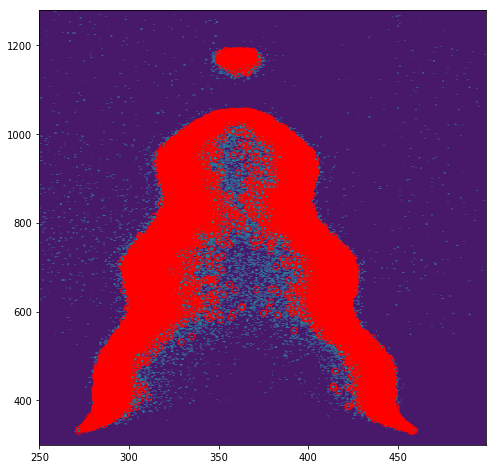

In [4]:
i_list = []
j_list = []
for i in range(0,1200,1):
    for j in range(0,800,1):
        if np_map1[i][j] == True:
            i_list.append(i)
            j_list.append(j)
            
print("Num data points (both halves): {}".format(len(i_list)))


x = [i for i in range(250, 500, 1)]
y = [i for i in range(300, 1280, 1)]

plt.contourf(x,y,np_map[300:1280,250:500])
plt.scatter(j_list, i_list, edgecolor= 'r', facecolor = 'None')
#plt.colorbar()
plt.show()

## Apply thinning

Num data points: 747


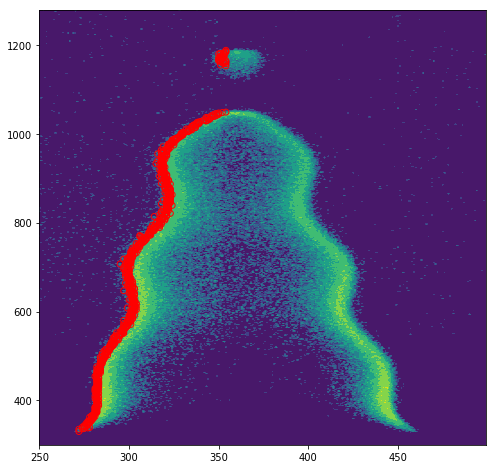

In [5]:
CENTER = 355

i_thin_list = []
j_thin_list = []
for i in range(len(i_list)):
    if i_list[i] not in i_thin_list and j_list[i] <= CENTER:
        i_thin_list.append(i_list[i])
        j_thin_list.append(j_list[i])
        
print("Num data points: {}".format(len(i_thin_list)))


plt.contourf(x,y,np_map[300:1280,250:500])
plt.scatter(j_thin_list, i_thin_list, edgecolor= 'r', facecolor = 'None')
#plt.colorbar()
plt.show()

## Define threshold + thinning function

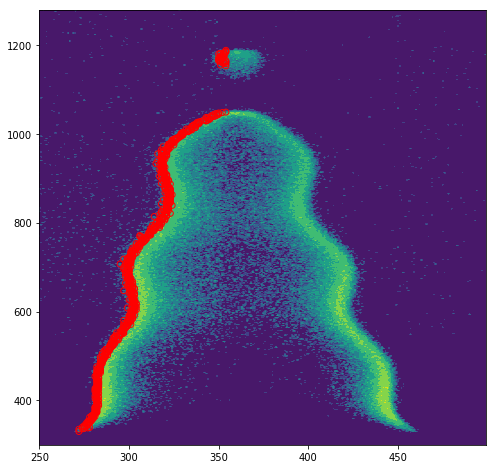

In [7]:
def thin_thresh(np_map, CENTER):
    np_map1 = threshold(np_map)
    i_list = []
    j_list = []
    for i in range(0,1200,1):
        for j in range(0,800,1):
            if np_map1[i][j] == True:
                i_list.append(i)
                j_list.append(j)
    
    #print("Num data points (both halves): {}".format(len(i_list)))
    
    i_thin_list = []
    j_thin_list = []
    for i in range(len(i_list)):
        if i_list[i] not in i_thin_list and j_list[i] <= CENTER:
            i_thin_list.append(i_list[i])
            j_thin_list.append(j_list[i])
    
    #print("Num thinned data points: {}".format(len(i_thin_list)))
    
    return i_thin_list, j_thin_list

CENTER = 355
i_thin_list, j_thin_list = thin_thresh(np_map, CENTER)
plt.contourf(x,y,np_map[300:1280,250:500])
plt.scatter(j_thin_list, i_thin_list, edgecolor= 'r', facecolor = 'None')
#plt.colorbar()
plt.show()

## Estimate St, K and ea is possible

In [8]:
####################################
# REAL St CALCULATION 
####################################

# Matthew's St calculation
wl = 950-700 # wavelength in number of vertical grid cells
radius_cells = 108
radius_mm = 6
wl = wl*radius_mm/radius_cells
L = radius_mm

St = L/wl
print(St)

#St = Lf/U calculation
f = 200
U = 2
St = L*f/U/1000
print(St)


####################################
# CONFIG St CALCULATION 
####################################

#from St calculation
beta = 15.8
St_config = 2*np.pi*beta*U*St
print(St_config)

#Hans config file St calculation
beta =  15.8
f = 200
L = 6/1000
St_config = 2*np.pi*beta*L*f
print(St_config)

0.432
0.6
119.12919342412496
119.12919342412496


## Run edge detection multiple times, saving indices (for res freq calculation) and coordinates (for LSGEN) separately

In [9]:
from matplotlib import gridspec

input_map = np.zeros((height, width), dtype='uint8')
output_map = np.zeros((height, width), dtype='uint8')

OUTLET = 333
CENTER = 355
RADIUS = 108

plt.ioff()
start_file = 300
end_file = 300
step = 10
for image_it in range(start_file,end_file,step):
    print("Image: {}".format(image_it))
    input_map[:, :] = imageio.imread("input.d/pinchOff-{}.png".format(image_it)).T[::-1, ::-1]
    output_map[:, :] = threshold(input_map)
    i_thin_list, j_thin_list = thin_thresh(input_map, CENTER)
    
    '''
    # Output.
    fig = plt.figure(image_it)
    ax = fig.gca()
    h = ax.contourf(output_map[200:1280, 200:500])
    fig.colorbar(h)
    fig.savefig("output.d/pinchOff-{}.png".format(image_it))
    plt.close(fig)
    
    # Inout.
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2)
    
    ax = plt.subplot(gs[0, 1])
    ax.contourf(input_map[200:1280, 200:500], cmap='gray')
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    ax = plt.subplot(gs[0, 0])
    ax.contourf(output_map[200:1280, 200:500])
    ax.set_aspect('equal')
    
    fig.savefig("inout.d/pinchOff-{}.png".format(image_it))
    plt.close(fig)
    '''
    # Write index text files.
    f = open("visualisation_inds.ref/surf_{}.dat".format(image_it), 'w')
    #f.write("{}\n".format(len(i_thin_list)))
    for i in range(len(i_thin_list)):
        x = j_thin_list[i]
        y = i_thin_list[i]
        f.write("{}\t{}\n".format(x, y))
    f.close()
    
    '''
    # Write text files.
    f = open("visualisation_inds.ref/surf_{}.dat".format(image_it), 'w')
    f.write("{}\n".format(np.nonzero(np.nonzero(output_map == True)[1] >= CENTER)[0].size))
    for loc_it in np.transpose(np.nonzero(output_map == True)):
        x = loc_it[1]
        y = loc_it[0]
        if x < CENTER:
            continue
        x = (x - CENTER) / RADIUS
        y = (y - OUTLET) / RADIUS
        f.write("{}\t{}\n".format(x, y))
    f.close()
    '''
plt.ion()

## Estimate resonant frequency

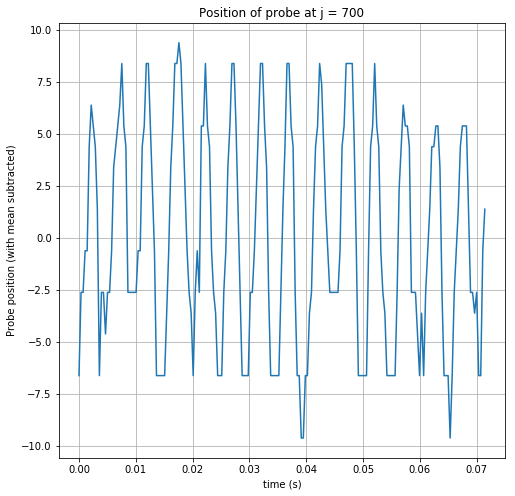

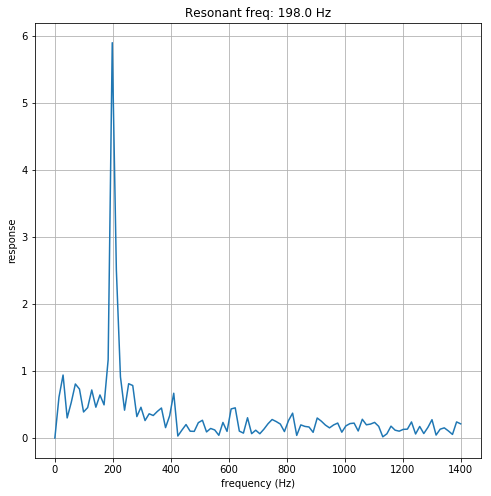

In [10]:
import scipy.fftpack as fftpack

probe_j = 700 # probe the point with this j (height) in each image
probe_i_hist = []

for i in range(0,2000,10):
    edge_data_file = 'visualisation_inds.ref/surf_' + str(i) + '.dat'
    data = np.loadtxt(edge_data_file)
    probe_i = []
    for row in data:
        if row[1] == probe_j:
            probe_i.append(row[0])
            break
    if probe_i:
        probe_i = np.mean(probe_i)
        probe_i_hist.append(probe_i)

'''
# Number of samplepoints
N = 150
# samp freq
sampFreq = 800
# sample spacing
T = 1.0 / sampFreq

x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0*0.5*np.sin(80.0 * 2.0*np.pi*x)
y = x
plt.plot(x,y)
plt.show()
yf = fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()
'''

###### Inputs ################################################
# Sampling freq
#sampFreq = 800
sampFreq = 2800

# Periodic data
#y = [np.sin(50.0 * 2.0*np.pi*x/sampFreq) for x in range(100)]
y = np.array(probe_i_hist) -np.mean(probe_i_hist)


###### FFT Calculation ########################################
# Number of sample points
N = len(y)
# Sample spacing
T = 1.0 / sampFreq
# Time stamp
x = np.linspace(0.0, N*T, N)

# Plot periodic signal
plt.plot(x,y)
plt.title('Position of probe at j = {}'.format(probe_j))
plt.xlabel('time (s)')
plt.ylabel('Probe position (with mean subtracted)')
plt.grid()
plt.show()

# Response
yf = fftpack.fft(y)
# Frequencies
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Plot FFT
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Resonant freq: ' + str(round(xf[abs(yf[:N//2]).argmax()],1)) + ' Hz')
plt.xlabel('frequency (Hz)')
plt.ylabel('response')
plt.grid()
plt.show()

## Estimate beta

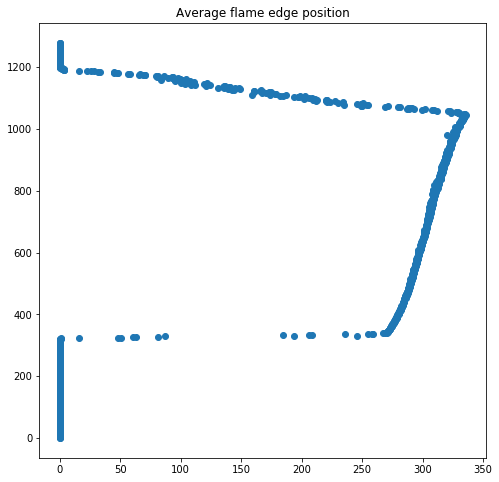

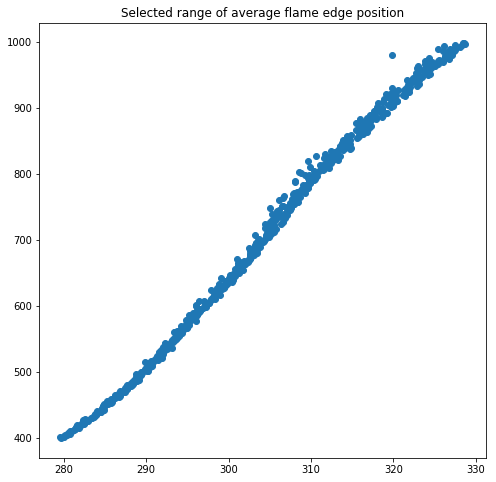

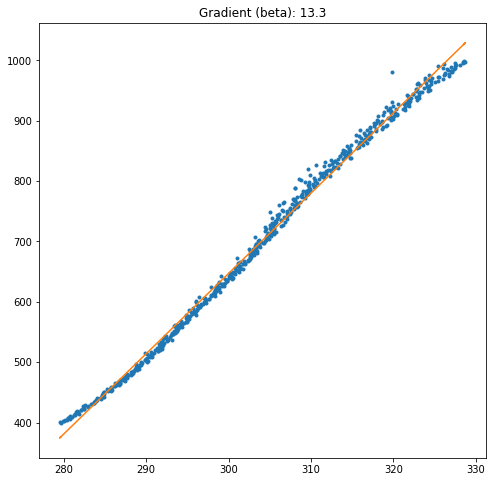

Estimate of beta: 13.3


In [11]:
from numpy.polynomial.polynomial import polyfit

j_positions = np.zeros(1280)

n_files = 0
for i in range(0,2000,10):
    n_files += 1
    edge_data_file = 'visualisation_inds.ref/surf_' + str(i) + '.dat'
    data = np.loadtxt(edge_data_file)
    probe_i = []
    for row in data:
        j_positions[int(row[1])] += row[0]

j_positions = j_positions/n_files
plt.scatter(j_positions,np.arange(1280))
plt.title('Average flame edge position')
plt.show()

# Select linear region
j_min = 400
j_max = 1000
j_straight = j_positions[j_min:j_max]
plt.scatter(j_straight, j_min+np.arange(len(j_straight)))
plt.title('Selected range of average flame edge position')
plt.show()

# Fit with polyfit
y = j_min+np.arange(len(j_straight))
x = j_straight
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.title('Gradient (beta): {}'.format(np.round(m,1)))
plt.show()

beta = np.round(m, 1)
print("Estimate of beta: {}".format(beta))